In [1]:
import sys
sys.path.append("../../")
import numpy as np
from tqdm import tqdm
import torch
from TorchInversion.TorchInversion import TorchInversion
from TorchInversion.propagators import Acoustic_Simulation
from TorchInversion.utils import dictToObj,numpy2tensor
from TorchInversion.plots import plot_model,plot_wavelet,plot_dampRegion,plot_observeSystem,wiggle
from TorchInversion.gradient_precond import grad_precond
from TorchInversion.demo import *

In [2]:
save_path = "./data/multiShotMiddle"

# initialize the Project
Project = TorchInversion(save_path=save_path)


2024-01-02 14:38:28,549:logs:INFO:Save To: ./data/multiShotMiddle
2024-01-02 14:38:28,550:logs:INFO:device: cuda:0
2024-01-02 14:38:28,552:logs:INFO:pid: 216638


In [3]:
##################################
# load parameters
##################################
model_config,source,receiver,vel_model = Project.loadConfig()

##################################
# optimizer
##################################
lr = 20
iteration = 500
step_size = 100
gamma = 0.75
device = "cuda:0"
optim_setting = Project.optimConfig(lr=lr,iteration=iteration,step_size=step_size,gamma=gamma,device=device)

##################################
# set the initial model
##################################
dx,dy = model_config.dx,model_config.dy
nx,ny = model_config.nx,model_config.ny
x = np.arange(0,ny*dy/1000,dx/1000)
y = np.arange(0,nx*dx/1000,dy/1000)
marmousi_model = load_marmousi_model(in_dir="./data/marmousi2_source/")
x_range = [5000, 13000]
y_range = [0, 3500]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)

# true and smooth model
model = resample_model(x, y, marmousi_model)
smooth_model = get_smooth_marmousi_model(model)

v = smooth_model['vp'].T
rho = np.power(v, 0.25) * 310
v_true = model['vp'].T
rho_true = np.power(v_true, 0.25) * 310

vel_model = Project.vel_model(v=v,rho=rho,model_config=model_config)

##################################
# save the inversion param
##################################
param = Project.saveConfig(model_config,source,receiver,vel_model,optim_setting,inversion=True)

2024-01-02 14:38:44,850:logs:INFO:
 ================ Model settings ================
nx	:	 80
ny	:	 179
dx	:	 44.7619
dy	:	 44.1679
nt	:	 1545
dt	:	 0.00317
pml	:	 15
fs	:	 1
nx_pml	:	 110
ny_pml	:	 209
vmax	:	 4791.634338863207
vmin	:	 1499.999913375916
2024-01-02 14:38:44,853:logs:INFO:
 ================ Source settings ================
f0	:	 5
src_x	:	 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65
src_y	:	 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
2024-01-02 14:38:44,855:logs:INFO:
 =============== Receiver settings ===============
rcv_x	:	 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
rcv_y	:	 1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 

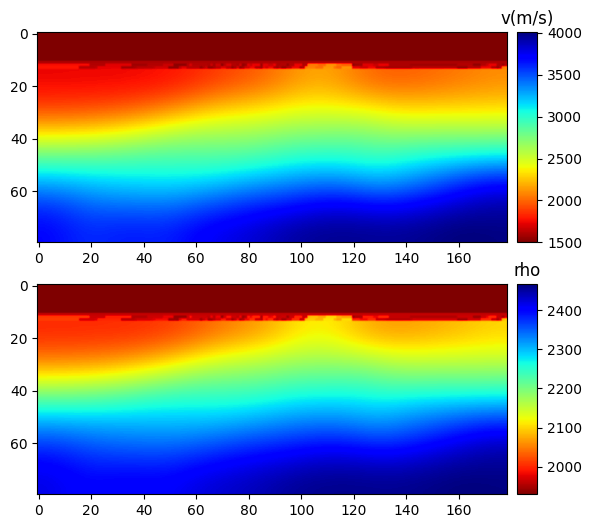

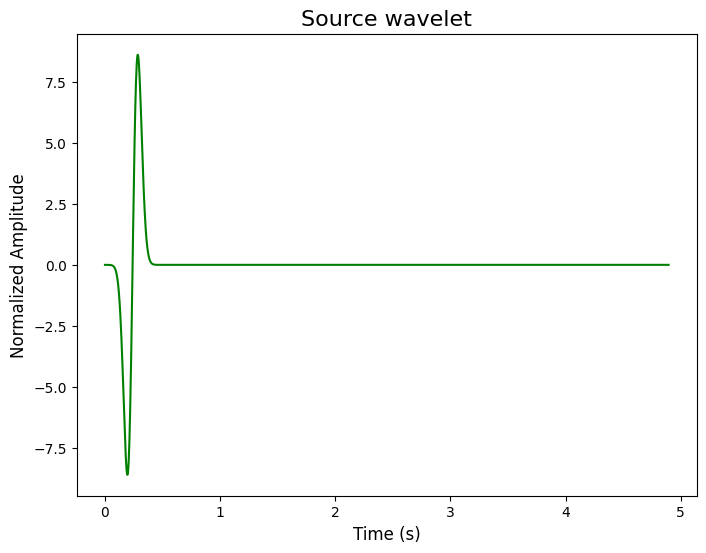

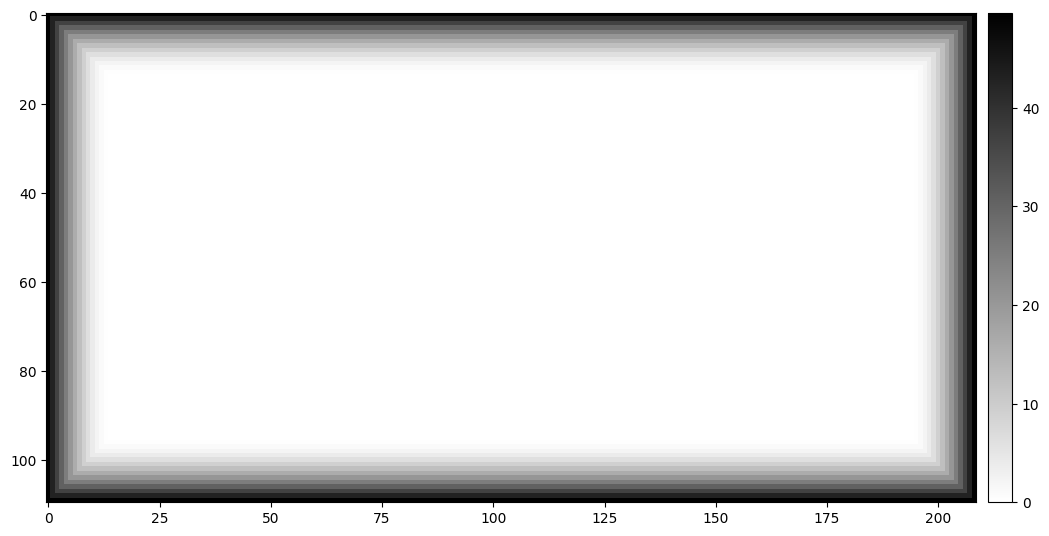

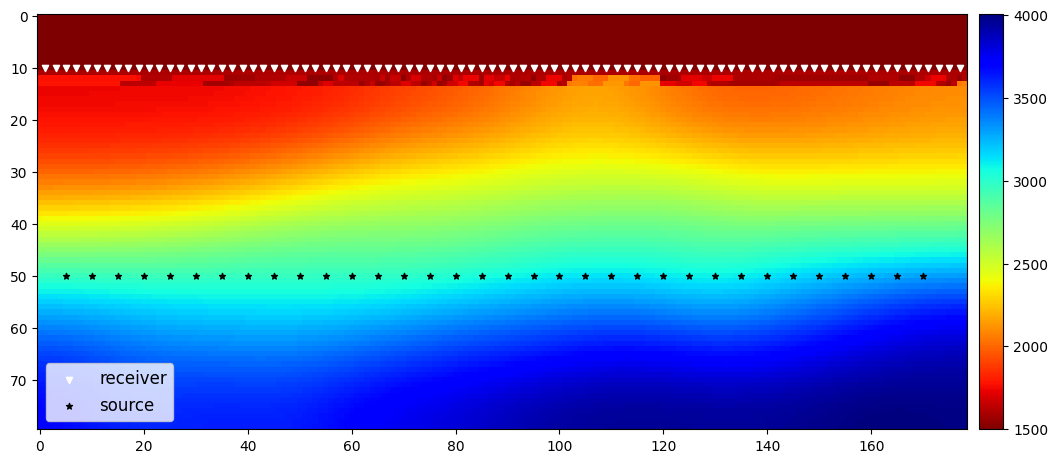

In [4]:
#Plot
plot_model(vel_model,save_path=os.path.join(save_path,"model/Initial/model_init.png"),show=True)
plot_wavelet(source,save_path=os.path.join(save_path,"model/Initial/ricker.png"),show=True)
plot_dampRegion(vel_model,save_path=os.path.join(save_path,"model/Initial/damp_global.png"),show=True)
plot_observeSystem(model_config,vel_model,source,receiver,save_path=os.path.join(save_path,"model/Initial/observed_system.png"),show=True)

In [5]:
#######################################
#         optimizer
#######################################
# observed data
csg_obs = np.load(os.path.join(save_path,"obs/obs.npz"))["obs_data"]

# grad precondition
grad_precondition = {
    "grad_mute":10,
    "grad_smooth":0,
    "marine_or_land":"Marine",
}

loss,inv_v = Project.inversion(csg_obs=csg_obs,normalize=True,grad_precondition=grad_precondition)

Using Adam to Iter the inversion


Iter:499,Loss:31.87: 100%|██████████| 500/500 [1:06:37<00:00,  8.00s/it]  
